# Manifold reconstruction of monkey (V1) LFP

In [16]:
import numpy as np
import mne
import os
import pywt
import scipy.io as sio
from scipy import signal
from scipy.signal import hilbert
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.stattools import acf
from scipy.ndimage import gaussian_filter1d


from stochastic_dynamics.models import AR, TAR
from stochastic_dynamics.embedders import embed
from stochastic_dynamics.pub_utils import *

# capture future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

set_pub_style()

In [17]:
def load_lfp_data(data_dir, file_names):
    data = [sio.loadmat(os.path.join(data_dir, fn)) for fn in file_names]
    LFP, Loc_X, Loc_Y, Elec_ID, Array_ID = [], [], [], [], []
    for d in data:
        LFP.append(d['lfp'])
        Loc_X.append(d['schematic_X_position'])
        Loc_Y.append(d['schematic_Y_position'])
        Elec_ID.append(d['Electrode_ID'])
        Array_ID.append(d['Array_ID'])
    return (np.concatenate(LFP, axis=1), np.concatenate(Loc_X), 
            np.concatenate(Loc_Y), np.concatenate(Elec_ID), np.concatenate(Array_ID))

def bandpass_filter(x, Fs, low, high, order=4):
    wn = [low/(Fs/2), high/(Fs/2)]
    sos = signal.butter(order, wn, btype='bandpass', output='sos')
    return signal.sosfiltfilt(sos, x)

def envelope_normalize(x, fs, fband=(15, 30), env_lp_hz=5.0, eps=1e-6):
    b, a = signal.butter(4, np.array(fband)/(fs/2), btype='bandpass')
    x_bp = signal.filtfilt(b, a, x)
    z = hilbert(x_bp)
    A = np.abs(z)
    if env_lp_hz is not None:
        b_lp, a_lp = signal.butter(2, env_lp_hz/(fs/2), btype='low')
        A = signal.filtfilt(b_lp, a_lp, A)
    x_flat = x_bp / (A + eps)
    x_flat *= np.median(A)
    return x_flat, x_bp, A

def process_signal(LFP, chan, Fs, time_window, 
                   notch_freq=50, notch_Q=30,
                   bandpass_low=1.0, bandpass_high=50.0,
                   fband=(1, 80), env_lp_hz=3.0):
    filtered = signal.filtfilt(*signal.iirnotch(notch_freq, notch_Q, Fs), LFP[time_window, chan])
    x = np.asarray(filtered).ravel()
    xs_raw = bandpass_filter(x, Fs, low=bandpass_low, high=bandpass_high)
    xs, _, _ = envelope_normalize(xs_raw, Fs, fband=fband, env_lp_hz=env_lp_hz)
    return xs, xs_raw

def fit_ar_model(xs, Fs, p=4, train_frac=0.9, refresh_every=5):
    X, y = AR.lag_matrix(xs, p)
    ntr = int(train_frac * len(y))
    X_tr, y_tr = X[:ntr], y[:ntr]
    w = AR.fit(X_tr, y_tr)
    N_te = len(y) - ntr
    t0 = p + ntr
    true_test = xs[t0 : t0 + N_te]
    yhat_ctrl = AR.hybrid_predict(xs, w, p, start_idx=t0, n_steps=N_te, refresh_every=refresh_every)
    full_pred = AR.hybrid_predict(xs, w, p, start_idx=p, n_steps=len(xs)-p, refresh_every=refresh_every)
    xs_pred_full = np.concatenate([xs[:p], full_pred])
    mse, mae, corr = AR.metrics(true_test, yhat_ctrl)
    return {
        'w': w, 'p': p, 'ntr': ntr, 'y': y, 'true_test': true_test,
        'yhat_ctrl': yhat_ctrl, 'xs_pred_full': xs_pred_full, 't0': t0,
        'mse': mse, 'mae': mae, 'corr': corr, 'refresh_every': refresh_every
    }


In [18]:
data_dir = '/home/rudra/Documents/StocasticDiffEq_Simulation/notebooks/data'
file_names = ['NSP1_array1_LFP.mat', 'NSP1_array2_LFP.mat', 'NSP2_array3_LFP.mat', 'NSP2_array4_LFP.mat', 
              'NSP3_array5_LFP.mat', 'NSP3_array6_LFP.mat', 'NSP4_array7_LFP.mat', 'NSP4_array8_LFP.mat', 
              'NSP5_array9_LFP.mat', 'NSP5_array10_LFP.mat', 'NSP6_array11_LFP.mat', 'NSP6_array12_LFP.mat', 
              'NSP7_array13_LFP.mat', 'NSP7_array14_LFP.mat', 'NSP8_array15_LFP.mat', 'NSP8_array16_LFP.mat']

Fs = 500
time_window = np.arange(10000)  # 20 seconds
chan = 1001

LFP, Loc_X, Loc_Y, Elec_ID, Array_ID = load_lfp_data(data_dir, file_names)
V4_chan = np.where((Array_ID == 2) | (Array_ID == 3))[0]
V1_chan = np.where((Array_ID != 2) & (Array_ID != 3))[0]

print(f"Loaded LFP: {LFP.shape} (samples x channels)")
print(f"V1 channels: {len(V1_chan)}, V4 channels: {len(V4_chan)}")

Loaded LFP: (1011623, 1024) (samples x channels)
V1 channels: 896, V4 channels: 128


In [19]:
xs, xs_raw = process_signal(LFP, chan, Fs, time_window,
                            bandpass_low=1.0, bandpass_high=50.0,
                            fband=(1, 80), env_lp_hz=3.0)

time = np.arange(len(xs)) / Fs
print(f"Processed channel {chan}: {len(xs)} samples")

Processed channel 1001: 10000 samples


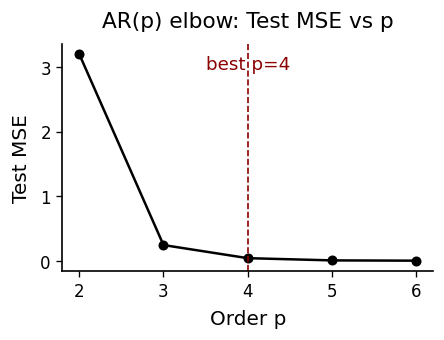

In [20]:
# Sweep AR orders for elbow plot
p_list = list(range(2, 7))
mse_te_list = []
for p in p_list:
    X, y_temp = AR.lag_matrix(xs, p)
    ntr_temp = int(0.9 * len(y_temp))
    X_tr, y_tr = X[:ntr_temp], y_temp[:ntr_temp]
    X_te, y_te = X[ntr_temp:], y_temp[ntr_temp:]
    w_temp = AR.fit(X_tr, y_tr)
    yhat_te = AR.predict_from_params(X_te, w_temp)
    mse_te, _, _ = AR.metrics(y_te, yhat_te)
    mse_te_list.append(mse_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]

def plot_mse_elbow(p_list, mse_list, best_p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(p_list, mse_list, marker='o', color=color_main, lw=1.5, ms=5)
    ax.axvline(best_p, linestyle='--', color=color_alt, linewidth=1)
    ax.text(best_p, ax.get_ylim()[1]*0.95, f"best p={best_p}", ha='center', va='top', color=color_alt, fontsize=11)
    sf = ScalarFormatter(useMathText=True)
    sf.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(sf)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.get_offset_text().set_size(10)
    prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
    plt.tight_layout()
    plt.show()

plot_mse_elbow(p_list, mse_te_list, 4)

In [21]:
ar_results = fit_ar_model(xs, Fs, p=4, train_frac=0.9, refresh_every=5)

w = ar_results['w']
p_use = ar_results['p']
ntr = ar_results['ntr']
y = ar_results['y']
true_test = ar_results['true_test']
yhat_ctrl = ar_results['yhat_ctrl']
xs_pred_full = ar_results['xs_pred_full']
REFRESH_EVERY = ar_results['refresh_every']

print(f"AR({p_use}): MSE={ar_results['mse']:.6f}, corr={ar_results['corr']:.3f}")

AR(4): MSE=23.665544, corr=0.995


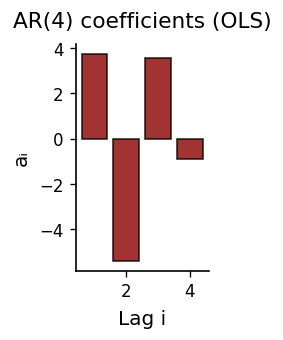

In [22]:
def plot_ar_coefficients(w, p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(2, 3))
    ax.bar(np.arange(1, p+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
    prettify(ax, title=f"AR({p}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
    plt.tight_layout()
    plt.show()

plot_ar_coefficients(w, p_use)

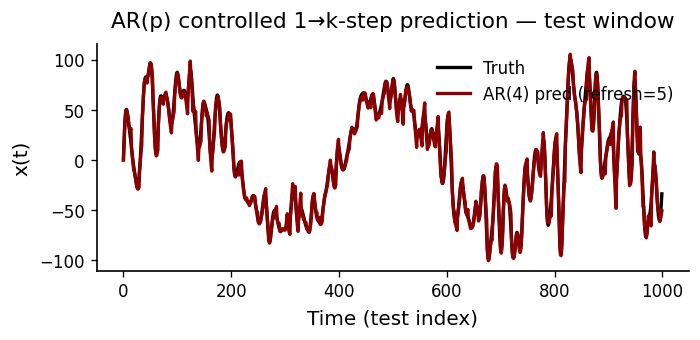

In [23]:
def plot_prediction(y_true, y_pred, p, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(y_true + 1, color=color_main, lw=2, label="Truth")
    ax.plot(y_pred, color=color_alt, lw=2, label=f"AR({p}) pred (refresh={refresh})")
    prettify(ax, title="AR(p) controlled 1→k-step prediction — test window",
             xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
    plt.tight_layout()
    plt.show()

plot_prediction(y[ntr:], yhat_ctrl, p_use, REFRESH_EVERY)

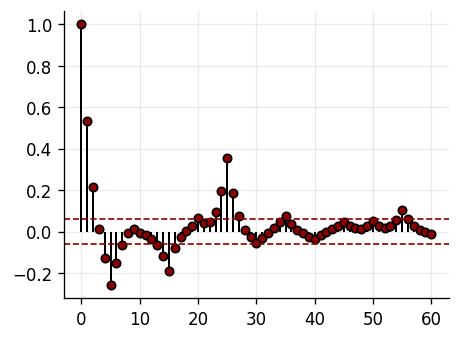

In [24]:
def plot_residual_acf(resid, nlags=60, color_main="black", color_alt="darkred"):
    acf_vals = acf(resid, nlags=nlags)
    bound = 1.96 / np.sqrt(max(len(resid), 1))
    fig, ax = plt.subplots(figsize=(4, 3))
    markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
    plt.setp(stemlines, color=color_main, linewidth=1.2)
    plt.setp(markerline, marker='o', markersize=5, markeredgecolor=color_main, markerfacecolor=color_alt)
    ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
    ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
    plt.tight_layout()
    plt.show()

resid_te = y[ntr:] - yhat_ctrl
plot_residual_acf(resid_te)

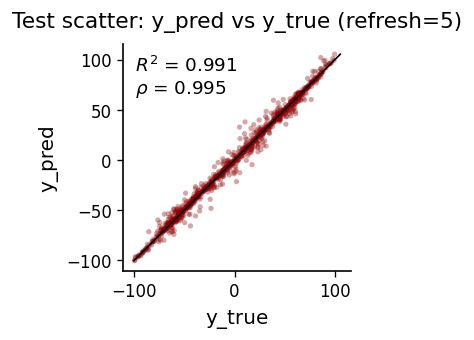

In [25]:
def plot_scatter(y_true, y_pred, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
    vmin, vmax = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))
    ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-12)
    ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
            transform=ax.transAxes, ha='left', va='top', fontsize=11,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
    ax.set_aspect('equal', adjustable='box')
    prettify(ax, title=f"Test scatter: y_pred vs y_true (refresh={refresh})", xlabel="y_true", ylabel="y_pred")
    plt.tight_layout()
    plt.show()

plot_scatter(y[ntr:], yhat_ctrl, REFRESH_EVERY)

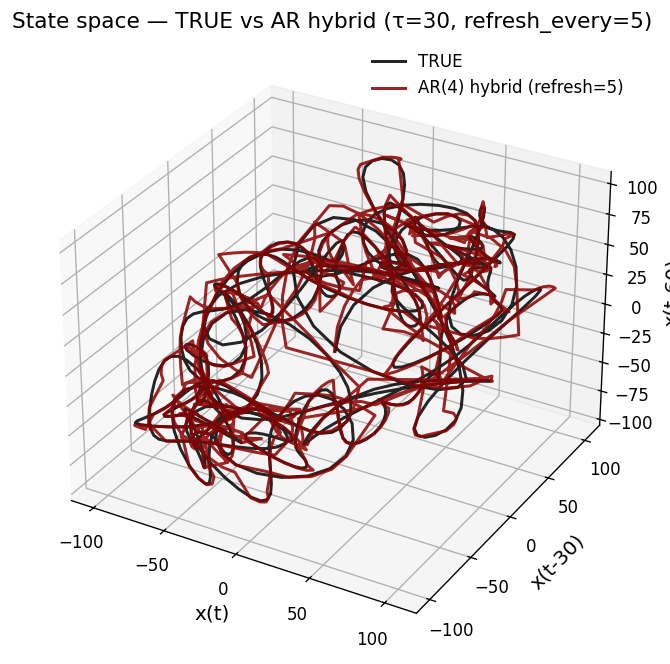

In [26]:
def plot_state_space(X3_true, X3_pred, p, tau, refresh, color_true="black", color_pred="darkred"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], label="TRUE", color=color_true, alpha=0.85)
    ax.plot(X3_pred[:,0], X3_pred[:,1], X3_pred[:,2], label=f"AR({p}) hybrid (refresh={refresh})", color=color_pred, alpha=0.85)
    ax.set_title(f"State space — TRUE vs AR hybrid (τ={tau}, refresh_every={refresh})")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t-{tau})")
    ax.set_zlabel(f"x(t-{2*tau})")
    ax.legend(frameon=False)
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)
    plt.tight_layout(pad=2.0)
    plt.show()

tau = 30
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed(true_test, 3, tau)
X3_hyb = embed(hy, 3, tau)

plot_state_space(X3_true, X3_hyb, p_use, tau, REFRESH_EVERY)

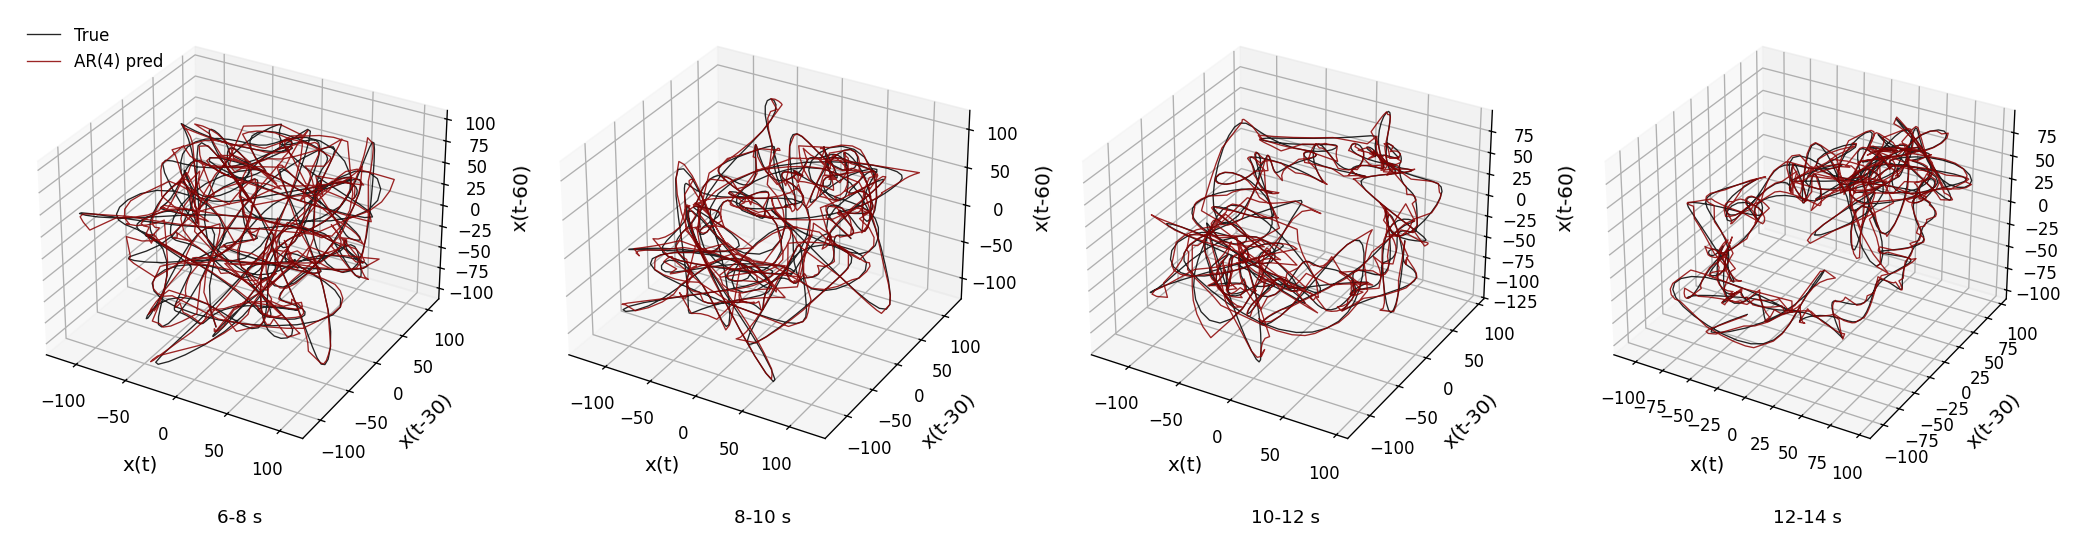

In [27]:

def plot_state_space_windows_comparison(xs, xs_pred, Fs, tau, embed_dim=3, 
                                         windows=[(6, 8), (8, 10), (10, 12), (12, 14)]):
    fig, axes = plt.subplots(1, 4, figsize=(len(windows)*4.5, 5), subplot_kw={'projection': '3d'})
    
    for ax, (t_start, t_end) in zip(axes, windows):
        idx_start = int(t_start * Fs)
        idx_end = int(t_end * Fs)
        
        # True signal
        segment_true = xs[idx_start:idx_end]
        X3_true = embed(segment_true, embed_dim, tau)
        
        # Predicted signal (variance-matched)
        segment_pred = xs_pred[idx_start:idx_end]
        seg_pred_matched = segment_pred - np.mean(segment_pred)
        seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
        seg_pred_matched = seg_pred_matched + np.mean(segment_true)
        X3_pred = embed(seg_pred_matched, embed_dim, tau)
        
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label='AR(4) pred')
        ax.set_xlabel("x(t)", labelpad=8)
        ax.set_ylabel(f"x(t-{tau})", labelpad=8)
        ax.set_zlabel(f"x(t-{2*tau})", labelpad=8)
        ax.tick_params(axis='both', pad=4)
        ax.text2D(0.5, -0.12, f"{t_start}-{t_end} s", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.12, top=0.95, wspace=0.15)
    plt.tight_layout(pad=2.5, w_pad=1.5)
    plt.savefig("1.pdf", bbox_inches='tight')
    plt.show()

# Build full prediction for visualization
full_pred = AR.hybrid_predict(xs, w, p_use, start_idx=p_use, n_steps=len(xs)-p_use, refresh_every=REFRESH_EVERY)
xs_pred_full = np.concatenate([xs[:p_use], full_pred])

plot_state_space_windows_comparison(xs, xs_pred_full, Fs, tau)

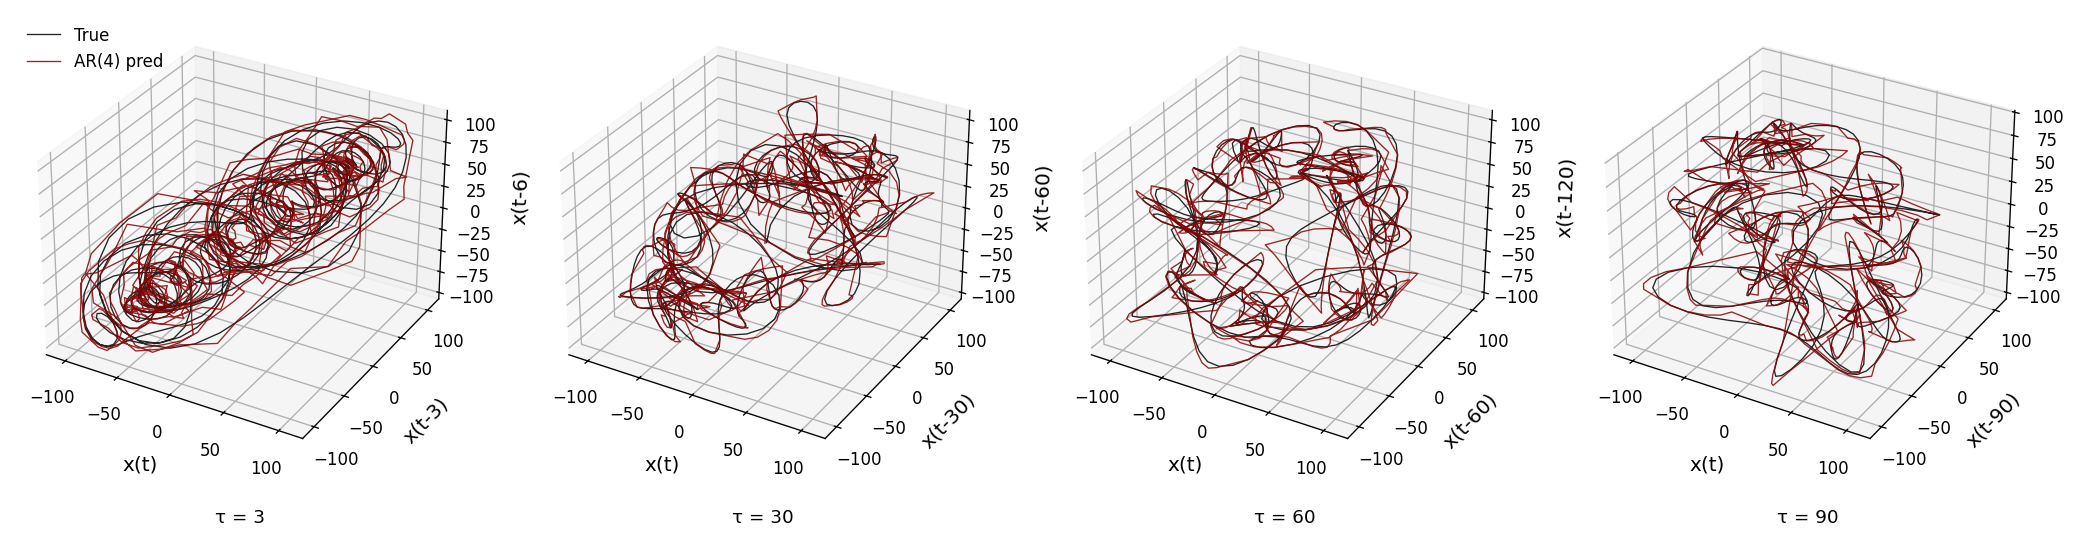

In [28]:

def plot_state_space_tau_sweep(xs, xs_pred, Fs, t_start, t_end, taus=[3, 30, 60, 90], embed_dim=3):
    fig, axes = plt.subplots(1, 4, figsize=(18, 5), subplot_kw={'projection': '3d'})
    
    idx_start = int(t_start * Fs)
    idx_end = int(t_end * Fs)
    segment_true = xs[idx_start:idx_end]
    segment_pred = xs_pred[idx_start:idx_end]
    
    # Variance-match prediction
    seg_pred_matched = segment_pred - np.mean(segment_pred)
    seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
    seg_pred_matched = seg_pred_matched + np.mean(segment_true)
    segment_pred
    for ax, tau_val in zip(axes, taus):
        X3_true = embed(segment_true, embed_dim, tau_val)
        X3_pred = embed(seg_pred_matched, embed_dim, tau_val)
        
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label='AR(4) pred')
        ax.set_xlabel("x(t)", labelpad=8)
        ax.set_ylabel(f"x(t-{tau_val})", labelpad=8)
        ax.set_zlabel(f"x(t-{2*tau_val})", labelpad=8)
        ax.tick_params(axis='both', pad=4)
        ax.text2D(0.5, -0.12, f"τ = {tau_val}", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.12, top=0.95, wspace=0.15)
    plt.tight_layout(pad=2.5, w_pad=1.5)
    plt.savefig("2.pdf", bbox_inches='tight')
    plt.show()

plot_state_space_tau_sweep(xs, xs_pred_full, Fs, t_start=18, t_end=20)

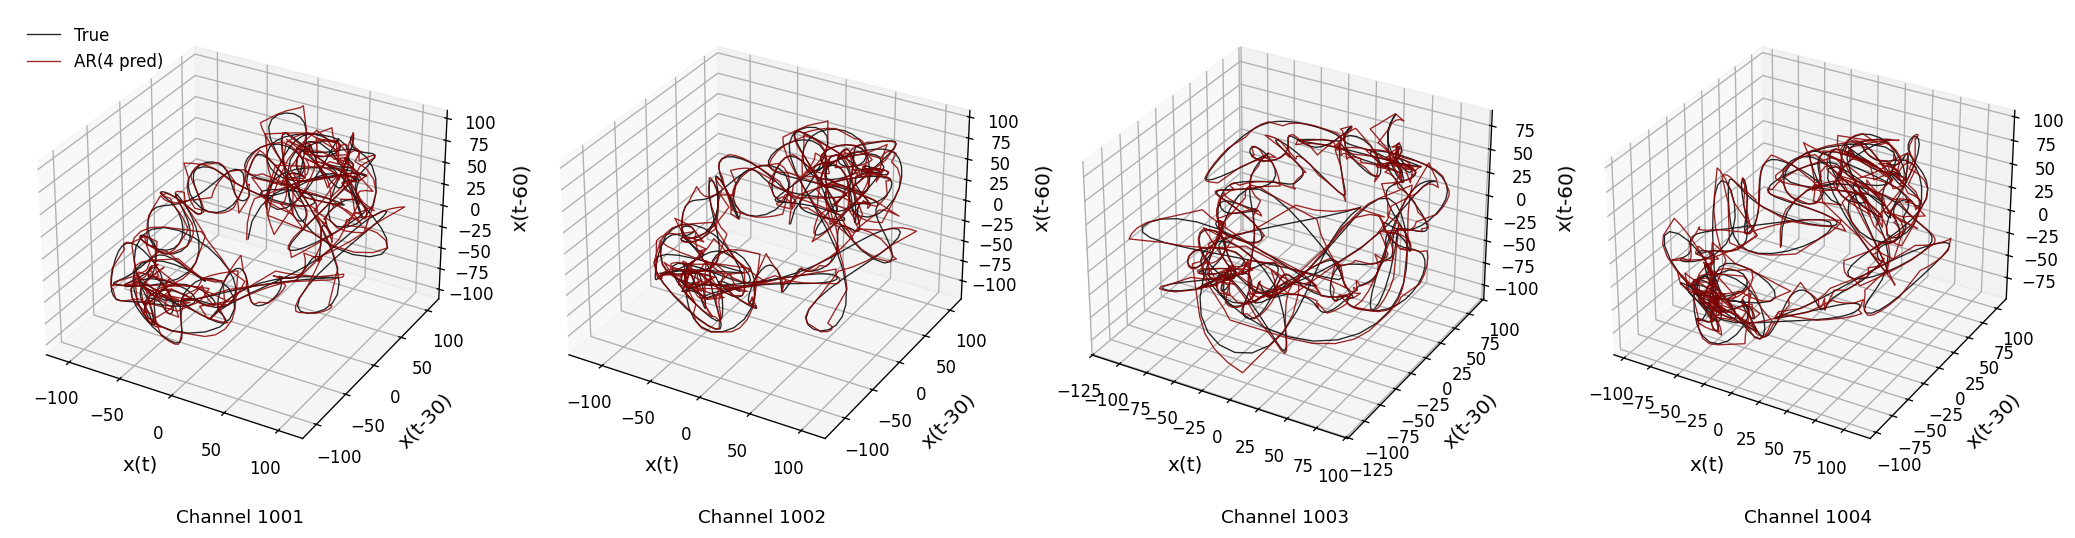

In [29]:
def sweep_channels_plot(LFP, channels, time_windows, taus, Fs, 
                        p=4, train_frac=0.9, refresh_every=5,
                        bandpass_low=1.0, bandpass_high=50.0, fband=(1, 80), env_lp_hz=3.0,
                        embed_dim=3):
    """
    Process multiple channels and plot state space comparison.
    
    Parameters
    ----------
    channels : list of int
        Channel indices to process
    time_windows : list of tuple
        (start_sec, end_sec) for each channel's plot window
    taus : list of int
        Embedding delay for each channel
    """
    n = len(channels)
    fig, axes = plt.subplots(1, n, figsize=(n*4.5, 5), subplot_kw={'projection': '3d'})
    if n == 1:
        axes = [axes]
    
    for ax, chan, (t_start, t_end), tau in zip(axes, channels, time_windows, taus):
        # Process full signal for this channel
        xs, _ = process_signal(LFP, chan, Fs, np.arange(int(t_end * Fs) + 100),
                               bandpass_low=bandpass_low, bandpass_high=bandpass_high,
                               fband=fband, env_lp_hz=env_lp_hz)
        
        # Fit AR model
        ar_res = fit_ar_model(xs, Fs, p=p, train_frac=train_frac, refresh_every=refresh_every)
        w, xs_pred_full = ar_res['w'], ar_res['xs_pred_full']
        
        # Extract window
        idx_start, idx_end = int(t_start * Fs), int(t_end * Fs)
        segment_true = xs[idx_start:idx_end]
        segment_pred = xs_pred_full[idx_start:idx_end]
        
        # Variance-match prediction
        seg_pred_matched = segment_pred - np.mean(segment_pred)
        seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
        seg_pred_matched = seg_pred_matched + np.mean(segment_true)
        
        # Embed
        X3_true = embed(segment_true, embed_dim, tau)
        X3_pred = embed(seg_pred_matched, embed_dim, tau)
        
        # Plot
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label=f'AR({p} pred)')
        ax.set_xlabel("x(t)", labelpad=8)
        ax.set_ylabel(f"x(t-{tau})", labelpad=8)
        ax.set_zlabel(f"x(t-{2*tau})", labelpad=8)
        ax.tick_params(axis='both', pad=4)
        ax.text2D(0.5, -0.12, f"Channel {chan}", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.12, top=0.95, wspace=0.15)
    plt.tight_layout(pad=2.5, w_pad=1.5)
    plt.savefig("3.pdf", bbox_inches='tight')
    plt.show()
    
sweep_channels_plot(
    LFP, 
    channels=[1001, 1002, 1003, 1004],
    time_windows=[(18, 20), (18, 20), (10, 12), (18, 20)],
    taus=[30, 30, 30, 30],
    Fs=Fs
)